# Generative Models

Generative models are increasingly popular, especially in public spheres where generative models like GPT, DALL-E (and other AI Art models) provide easy to use APIs for the public to interact with generative models. 

The goal of generative modelling is to learn how to create new inputs (images, tabular data...etc) that have similar properties to the training data. Generally this can be accomplished in two ways:

- **Density Estimation**: where the model learns an explicit probability density function that it can sample from (e.g. Naive Bayes, Gaussian Mixture Models, and Variational Autoencoders)
- **Sample Generation**: where the model learns a function that can generate new stimuli without explicity density estimation (such as Generative Adversarial Networks which we'll cover next.)

## Naive Bayes
In Naive Bayes modles, we model a probability distribution that tells us the probability of data points having a given feature.

For categorical variables, we can do this by simple calculation the proportion of rows with each feature.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC393ParlettPelleriti/main/Data/nbgenerative.csv")
df.head()

,hair_color,eye_color,gender_presentation,hair_style
0,brown,brown,masculine,short
1,blonde,blue,feminine,short
2,brown,hazel,masculine,medium
3,brown,brown,feminine,long
4,red,brown,feminine,short


Let's calculate our probability distribution based on these 4 characteristics for emoticons.

In [2]:
hair_probs = df.groupby("hair_color")["hair_color"].count()/df.shape[0]

eye_probs = df.groupby("eye_color")["eye_color"].count()/df.shape[0]

gender_probs = df.groupby("gender_presentation")["gender_presentation"].count()/df.shape[0]

style_probs = df.groupby("hair_style")["hair_style"].count()/df.shape[0]

# print(pd.DataFrame(hair_probs).to_markdown(tablefmt="grid"))
# print(pd.DataFrame(eye_probs).to_markdown(tablefmt="grid"))
# print(pd.DataFrame(gender_probs).to_markdown(tablefmt="grid"))
# print(pd.DataFrame(style_probs).to_markdown(tablefmt="grid"))


+--------------+--------------+
| hair_color   |   hair_color |
+==============+==============+
| black        |         0.05 |
+--------------+--------------+
| blonde       |         0.21 |
+--------------+--------------+
| blue         |         0.01 |
+--------------+--------------+
| brown        |         0.51 |
+--------------+--------------+
| purple       |         0.07 |
+--------------+--------------+
| red          |         0.12 |
+--------------+--------------+
| white        |         0.03 |
+--------------+--------------+



+-------------+-------------+
| eye_color   |   eye_color |
+=============+=============+
| blue        |        0.16 |
+-------------+-------------+
| brown       |        0.52 |
+-------------+-------------+
| green       |        0.11 |
+-------------+-------------+
| hazel       |        0.21 |
+-------------+-------------+



+-----------------------+-----------------------+
| gender_presentation   |   gender_presentation |
+=======================+=======================+
| androgenous           |                  0.09 |
+-----------------------+-----------------------+
| feminine              |                  0.53 |
+-----------------------+-----------------------+
| masculine             |                  0.38 |
+-----------------------+-----------------------+



+--------------+--------------+
| hair_style   |   hair_style |
+==============+==============+
| long         |         0.47 |
+--------------+--------------+
| medium       |         0.26 |
+--------------+--------------+
| short        |         0.27 |
+--------------+--------------+



Now, let's generate some new data by sampling from the probability distribution we just calculated. Notice that we're assuming that these features (hair color, eye color, gender presentation, and hair style) are *independent* even though that may not be true.

In [3]:
np.random.seed(1234)
new_hair = np.random.choice(hair_probs.index, size = 10, p = hair_probs, replace = True)
new_eyes = np.random.choice(eye_probs.index, size = 10, p = eye_probs, replace = True)
new_gender = np.random.choice(gender_probs.index, size = 10, p = gender_probs, replace = True)
new_style = np.random.choice(style_probs.index, size = 10, p = style_probs, replace = True)

new_data = pd.DataFrame({"hair_color": new_hair, 
                         "eye_color": new_eyes,
                         "gender_presentation": new_gender,
                         "hair_style": new_style})

new_data

,hair_color,eye_color,gender_presentation,hair_style
0,blonde,brown,feminine,short
1,brown,brown,feminine,long
2,brown,green,androgenous,short
3,purple,green,feminine,long
4,brown,brown,masculine,medium
5,brown,brown,masculine,medium
6,brown,brown,feminine,long
7,purple,blue,masculine,short
8,red,green,feminine,long
9,red,hazel,feminine,short


We've built a generative model! Let's see if our generative model created any never-before-seen emoji people. We can do this by finding rows that only appear in `new_data` and not `df`.


In [4]:
# find rows only located in new_data OR df
find_new_rows = pd.merge(df, new_data, on = ['hair_color', 'eye_color', 'gender_presentation', 'hair_style'], \
         how = "outer", indicator= True)

# pull rows in new_data that never occur in df
find_new_rows[find_new_rows["_merge"] == "right_only"]

,hair_color,eye_color,gender_presentation,hair_style,_merge
113,brown,green,androgenous,short,right_only
114,purple,green,feminine,long,right_only
115,purple,blue,masculine,short,right_only
116,red,green,feminine,long,right_only
117,red,hazel,feminine,short,right_only


Wow! It looks like we generated a few never-before-seen emoji people!


## Gaussian Mixture Models

We also learned that Gaussian Mixture Models can be generative models. In GMM we ask the model to learn the mean and covariance of all of our clusters. Once we have the multi-variate normal distributions created by the model, we can sample new data from them. In fact, `sklearn` has a function for that `.sample()`!


In [5]:
penguins = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/penguins.csv")
penguins.dropna(inplace = True)
penguins.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


First, we'll fit a Gaussian Mixture model on the `bill_length_mm` and `bill_depth_mm` features. Then we'll use the built-in `sample` method to generate new samples from each group.

In [6]:
from sklearn.mixture import GaussianMixture

# grab data
features = ["bill_length_mm", "bill_depth_mm"]
X = penguins[features]

# fit model
gmm = GaussianMixture(n_components = 3)
gmm.fit(X)

# sample new data
samples = gmm.sample(20)
new_penguins = pd.DataFrame(samples[0])
new_penguins.columns = features
new_penguins["cluster"] = samples[1]

new_penguins.head()


,bill_length_mm,bill_depth_mm,cluster
0,37.183855,19.643451,0
1,38.320232,17.649347,0
2,40.024318,16.129391,0
3,39.415598,17.634835,0
4,40.234191,20.041773,0


looks like we've generated some new, realistic looking penguins!

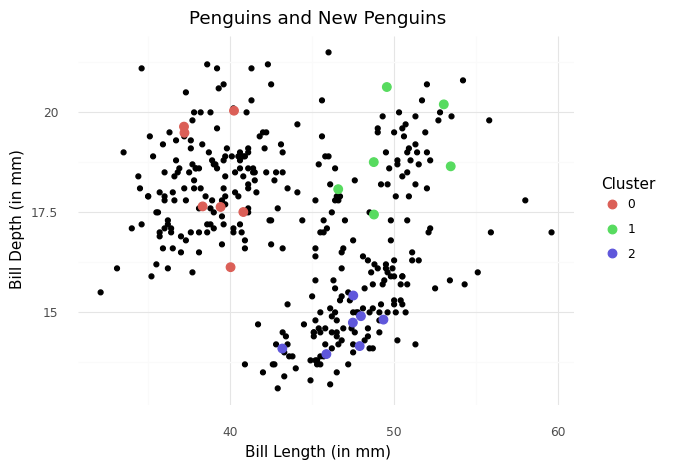

<ggplot: (316562655)>

In [7]:
# plot
from plotnine import *

(ggplot(penguins, aes(x = "bill_length_mm", y = "bill_depth_mm")) + geom_point() + 
geom_point(data = new_penguins, mapping = aes(color = "factor(cluster)"), size = 3) + 
labs(x = "Bill Length (in mm)", y = "Bill Depth (in mm)", 
     title = "Penguins and New Penguins")  + 
     theme_minimal() + 
     scale_color_discrete(name = "Cluster")) 


## Variational Autoencoders

Naive Bayes and GMM are simple generative models that learn explicity probability distributions for our data, allowing us to sample from these distributions. 

Variational Autoencoders work similarly. Like a regular Autoencoder, VAEs use an encoder to learn how to represent input data using a **hiddent representation** in a **latent space** in a way that allows the decoder to recrate that input using only the hidden representation. But unlike regular Autoencoders, we want to encourage VAEs to learn a **hidden representation** that has nice properties. Specifically we want this latent space to have:

- **Good Representation**: the model learns a hidden representation that allows the model to accurately recreate the input
- **Good Realisim**: the model learns a latent space where any point in the latent space creates a *valid* looking sample
- **Good Smoothness**: the model learns a latent space where we can sample points between two inputs in order to get a smooth morphing from one input to the other


In order to enforce these properties, variational autoencoders do two important things to distinguish themselves from regular autoencoders:

### 1. Probabilistic Hidden Representations

Instead of learning a deterministic hidden representation (like a single vector of numbers), VAEs learn a *probabilistic* hidden representation by learning a vector of *means* ($\mu$) and a vector of variances ($\sigma^2$). These represent a multivariate normal probability distribution that we can sample hidden representation vectors from by using the formula: 

$$ \text{hidden representation} = \mu + \sigma * \zeta $$

where $\mu$ and $\sigma$ are learned by the encoder, and $\zeta$ is randomly sampled noise that is not learned by the model. 

Because we still expect the decoder to recreate the orginal input despite the addition of randomness, this forces the VAE to learn that similar hidden representations should produce similar outputs (this is a similar idea to **Contractive Autoencoders** where we penalized the derivative of the encoder so that small changes in the input didn't result in large changes in the output: aka similar inputs should have similar hidden representations). 


### 2. Regularization Loss

In a typical Autoencoder, there's nothing in the loss function that says that the latent space of our hidden representations should be well behaved, but we'd like them to be well behaved. So, we add a term to our loss function. 

An Autoencoder typically uses only the **Reconstruction Loss** to train the model. This measures the MSE comparing the input to the re-created output. The closer these two things are, the better our Autoencoder is. 

$$ \text{AE loss} = || x = \hat{x}||^2 $$

VAEs also use reconstruction loss (after all, we still care that our inputs can be recreated) but we also want a nice latent space, so we add a regularizing term to the loss function.

$$ \text{VAE loss} = || x = \hat{x}||^2 + KL(N(\mu, \sigma), N(0,1)) $$

Remember, **KL Divergence** measures the similarity between two distributions. So our penalty term penalizes the model if the $\mu$ and $\sigma$ that the model learns are far away from $0$ and $1$. This does NOT mean that the values it learns *can't* be far away from $0$ and $1$, but if they are, they must commensurately improve the reconstruction loss. 

Let's look at a [modified example from Keras](https://colab.research.google.com/drive/1vjwM48on5X-ZsNkmtQq0QtgPK13rIVaX?usp=sharing), where we build a Variational Autoencoder on the Fashion MNIST dataset. Read through and run the code then discuss the following with your group:

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = "200"/>

1. What kinds of layers does the encoder have?
- 2D convolutional layers
- Dense layers

2. What does the encoder output (is it more than one thing?)
3. What does the encoder use to *downsample* the input image? Why, according to the lecture, do we make that choice?
4. Can you figure out what the `Sampling()` function does? 
5. What does the decoder take in? What does it output?
6. How is the decoder *upsampling* the hidden representation to make its output the same shape as our original image?
7. We have to define a custom loss function for this VAE (see `line 32` under the **Define the VAE as a `Model` with custom `train_step`** section), what does this custom loss function include?
8. Look at the plot under the cell **Display a grid of sampled clothes**. Does our latent space have the property of **Smoothness**?
9. (this is a bit of a tough question, feel free to use outside resources) Looking at the plot under the cell **Display how the latent space clusters different clothes classes**, does our latent space look like you expect it to? If so: what about our model helped it look that way? If not: what would we change about our model in order for it to look the way we expect?